In [1]:
import torch

from torch import nn
from thop import profile
from resnet import resnet_18
from matplotlib import pyplot as plt
from data.cifar100 import build_dataset, PATH
from data.cifar100 import getFineLabelNameDict

name_dir = getFineLabelNameDict()

In [35]:
def try_all_gpus():
    devices = [torch.device(f'cuda:{i}') for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]


def get_cifar_100_labels(labels):
    return [name_dir[int(i)] for i in labels]


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [36]:
devices = try_all_gpus()
dataset_val, num_classes = build_dataset(is_train=False, path=PATH)
model = resnet_18(input_channels=3, num_class=100)
flops, params = profile(model, inputs=(torch.randn(1, 3, 32, 32),))
print(f"params: {params / 1e6:.2f}M, FLOPs: {flops / 1e9:.2f}B (in Tensor(1, 3, 32, 32))")
model = nn.DataParallel(model, device_ids=devices).to(devices[0])
model.load_state_dict(torch.load(f"work_dir/resnet_18/resnet_18_2023_08_26_13_38_57_epoch100.pth")['model'])

Files already downloaded and verified
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
params: 11.22M, FLOPs: 0.56B (in Tensor(1, 3, 32, 32))


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


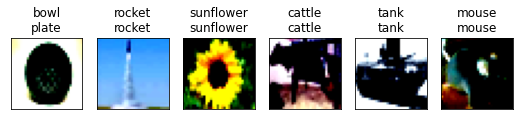

In [37]:
def predict(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues = get_cifar_100_labels(y)
    preds = get_cifar_100_labels(torch.argmax(net(X), axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X.permute(0, 2, 3, 1), 1, n, titles=titles[0:n])
    
model.eval()
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=6, shuffle=True, num_workers=0, drop_last=False)
predict(model, data_loader_val)